
# Protocol 1: assessment of cell type replicability with unsupervised MetaNeighbor

Protocol 1 demonstrates how to compute and visualize cluster replicability across 4 human pancreas datasets. We will show steps detailing how to install MetaNeighbor, how to compute and interpret MetaNeighbor AUROCs. All code blocks can be run in a Jupyter notebook, python or ipython interpretor or in a script run at the command line.

## Step 0: Installation of MetaNeighbor and packages used in the protocol

1. We start by installing the latest MetaNeighbor package from the Gillis lab GitHub page if you have not done so already. 

Uncomment the line in the cell below and run it, if you run into errors with the installation, refer to the installation information in the [README](https://github.com/gillislab/pymn)


In [1]:
#!pip install git+https://github.com/gillislab/pyMN#egg=pymn

2. Next we need to import other packages needed to run this analysis, all of these are required by pyMN anyway so you should have them if it successfully installs

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pymn

In [3]:
%matplotlib inline

3. Here we set up our plotting settings, these are our preferences

In [4]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

## Step 1: Downloading the Hemberg scRNAseq data

We consider 4 pancreatic datasets along with their independent annotation (from the original publication). MetaNeighbor expects a gene x cell matrix encapsulated in a anndata format. In python we reccomend using the anndata object. It is works well with the popular scRNAseq analysis package Scanpy. The 4 datasets are best aquired using the R package scRNAseq. In the equilavent protocol the R version of MetaNeighbor we outline how to aquire and preprocess each individual dataset. 

Merging the R SingleCellExperiement objects proves to be quite difficult. In the R version the protocol provides functions and a tutorial on how to do it in R. Merging python anndata objects is relatively straightforward, but if you have difficulty the the [anndata documentation](https://anndata.readthedocs.io/en/stable/concatenation.html) has a section dedicated to it. For the BICCN data used in Protocols 2 and 3, when processing the data we merged 7 Anndata objects. To follow how the data was processed you can refer to this [R script](https://github.com/gillislab/pyMN/blob/master/data/hemberg.R) and this [Python script](https://github.com/gillislab/pyMN/blob/master/data/hemberg.py). Running the Rscript requires installing the R version of [MetaNeigbhor](https://github.com/gillislab/MetaNeighbor) and the Bioconductor package [scRNAseq](https://bioconductor.org/packages/3.12/scRNAseq)
4. First we need to download the data using `curl`

In [5]:
!curl -L -o hemberg.h5ad https://ndownloader.figshare.com/files/24928574

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 97.2M  100 97.2M    0     0  12.7M      0  0:00:07  0:00:07 --:--:-- 14.4M


## Step 2: Hierarchical cell type replicability analysis

5. We load the previously created pancreas dataset.

In [6]:
adata = sc.read_h5ad('hemberg.h5ad') #Temporary until hosted file

In [7]:
adata.obs.columns = adata.obs.columns.astype(str)

Here you can see that we have an AnnData object iwth 15,793 cells and 15,295 genes

It has two observation features: `cell.type` and `study_id`

In [8]:
adata

AnnData object with n_obs × n_vars = 15793 × 15295
    obs: 'cell.type', 'study_id'

6. Study and Cell Type Data must be passed as a string or integer to MetaNeigbhor fast version for the computation to be sped up

In [9]:
adata.obs['cell.type'] = adata.obs['cell.type'].astype(str)
adata.obs['study_id'] = adata.obs['study_id'].astype(str)

7. To perform neighbor voting, MetaNeighbor builds a cell-cell similarity network, which we defined as the Spearman correlation over a user-defined set of genes. We found that we obtained best results by picking genes that are highly variable across datasets, which can be picked using the "variableGenes" function.


>**NOTE**: This is the one function that differs slightly from the R version. The quantile function in R defaults to a behavoir that is not native to any standard python packages, thus the variable gene list is slightly different between the python and R versions. Overall this does not appear to affect the results significantly. While the AUROCs will not be identical they are extremely similar. In Section 1.4 there are a few differences in connectivity between individual clusters, but the neighborhood structure of the cell-type graph is consistent

In [10]:
pymn.variableGenes(adata, study_col='study_id')

/home/bharris/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


The function returns a list of 736 (600 in the R version) genes that were detected as highly variable in each of the 4 datasets. By default the `variableGenes` functions stores the highly variable genes under the `highly_variable` column in `.var` of the passed AnnData object

8. The data and a set of biological meaningful genes is all we need to run MetaNeighbor and obtain cluster similarities.

>**NOTE**: Most functions do not return anything by default. Rather they save the output of the function in the `.uns` part of the anndata object. Additionally, by default the functions search for input data from the `.uns` data. This functionality is highly customizable, you can pass objects directly if you want and return the results instead of saving them from the object. Additionally, you can define your own keys to save results as instead of the defaults. __EX__: The output of the below `MetaNeighborUS` run is save in `adata.uns['MetaNeighborUS']` and the parameters uses are saved under `adata.uns['MetaNeighborUS_params']`

In [11]:
pymn.MetaNeighborUS(adata,
                    study_col='study_id',
                    ct_col='cell.type',
                    fast_version=True)

Cluster similarities are defined as an Area Under the ROC curve (AUROC), which range between 0 and 1. The cross-dataset voting framework makes it batch-effect free (very different from average correlation)

9. For ease of interpretation the results can be visualized as a symmetric heatmap, where rows and columns are clusters from all datasets.

/home/bharris/miniconda3/lib/python3.7/site-packages/seaborn/matrix.py:1215: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


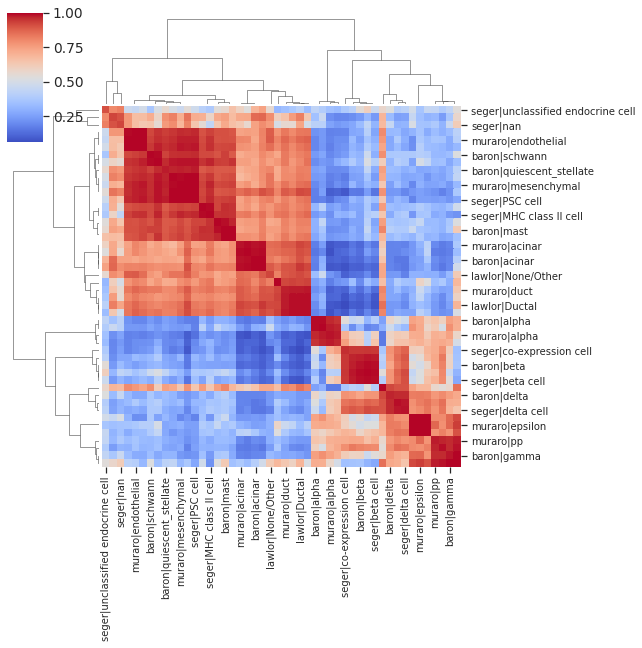

In [12]:
pymn.plotMetaNeighborUS(adata, figsize=(10, 10), cmap='coolwarm', fontsize=10)

In the heatmap, the color of each square indicates the proximity of a pair of cluster, ranging from blue (low similarity) to red (high similarity). For example, "serger|gamma cell" (bottom row) is highly similar to "muraro|pp" (2nd column from the right) but very dissimilar from "muraro|ductal" (middle column). To group similar clusters together, "plotHeatmap" applies hierarchical clustering on the AUROC matrix. On the heatmap, we see two red blocks that indicate clear hierarchical structure in the data, with endocrine cell types clustering together (e.g., alpha, beta, gamma) and mesenchymal cells on the other side (e.g., amacrine, ductal, endothelial). Note that each red block is composed of smaller red blocks, indicating that clusters can be matched at an even higher resolution. We also see some off-diagonal patterns (e.g., lawlor|Gamma/PP, lawlor|Delta), which generally indicate the presence of doublets or contamination (presence of cells from other cell types), but what matters here is the clear presence of red blocks, which is a strong indicator of replicability.

10. To identify pairs of replicable clusters, we rely on a simple heuristics: a pair of cluster is replicable if they are reciprocal top hits (they preferentially vote for each other) and the AUROC exceeds a given threshold value (in our experience, 0.9 is a good heuristic value).

In [13]:
pymn.topHits(adata, threshold=0.9)

adata.uns['MetaNeighborUS_topHits']

,Study_ID|Celltype_1,Study_ID|Celltype_2,Mean_AUROC,Match_type
0,seger|epsilon cell,muraro|epsilon,1.00,Reciprocal_top_hit
1,baron|epsilon,seger|epsilon cell,1.00,Above_0.9
2,seger|PSC cell,lawlor|Stellate,1.00,Reciprocal_top_hit
3,seger|endothelial cell,muraro|endothelial,1.00,Reciprocal_top_hit
4,muraro|mesenchymal,seger|PSC cell,1.00,Above_0.9
5,seger|mast cell,baron|mast,1.00,Reciprocal_top_hit
6,baron|activated_stellate,seger|PSC cell,1.00,Above_0.9
7,baron|endothelial,muraro|endothelial,1.00,Above_0.9
8,lawlor|Gamma/PP,baron|gamma,1.00,Reciprocal_top_hit
9,lawlor|Acinar,baron|acinar,1.00,Reciprocal_top_hit


We find a long list of replicable endocrine cell types (e.g., epsilon, alpha and beta cells) and non-endocrine cell types (e.g. mast, endothelial or acinar cells). This list provides strong evidence that these cell types are robust, as they are identified across all datasets with high AUROC.

11. In the case where there is a clear structure in the data (endocrine vs non-endocrine here), we can refine AUROCs by splitting the data. AUROCs have a simple interpretation: an AUROC of 0.6 indicates that cells from a given cell type are ranked in front of 60% of other test cells. However, this interpretation is outgroup dependent: because endocrine cells represent ~65% of cells, even an unrelated pair of non-endocrine cell types will have an AUROC > 0.65, because non-endocrine cells will always be ranked in front of endocrine cells.

By starting with the full datasets, we uncovered the global structure in the data (endocrine vs non-endocrine). However, to evaluate replicability of endocrine cell types and reduce dataset composition effects, we can make the assessment more stringent by restricting the outgroup to close cell types, i.e. by keeping only endocrine subtypes. We split cell types in two by using the splitClusters function and retain only endocrine cell types.

In [14]:
level1_split = pymn.splitClusters(
    adata, k=2,
    save_uns=False)  #Returning the splitClusters instead of saving them
level1_split

[array(['baron|acinar', 'baron|activated_stellate', 'baron|ductal',
        'baron|endothelial', 'baron|macrophage', 'baron|mast',
        'baron|quiescent_stellate', 'baron|schwann', 'baron|t_cell',
        'lawlor|Acinar', 'lawlor|Ductal', 'lawlor|None/Other',
        'lawlor|Stellate', 'muraro|acinar', 'muraro|duct',
        'muraro|endothelial', 'muraro|mesenchymal', 'muraro|nan',
        'muraro|unclear', 'seger|MHC class II cell', 'seger|PSC cell',
        'seger|acinar cell', 'seger|ductal cell', 'seger|endothelial cell',
        'seger|mast cell', 'seger|nan', 'seger|unclassified cell',
        'seger|unclassified endocrine cell'], dtype=object),
 array(['baron|alpha', 'baron|beta', 'baron|delta', 'baron|epsilon',
        'baron|gamma', 'lawlor|Alpha', 'lawlor|Beta', 'lawlor|Delta',
        'lawlor|Gamma/PP', 'muraro|alpha', 'muraro|beta', 'muraro|delta',
        'muraro|epsilon', 'muraro|pp', 'seger|alpha cell',
        'seger|beta cell', 'seger|co-expression cell', 'seger|del

In [15]:
first_split = level1_split[1]

By outputting “level1_split”, we found that the cell types were nicely split between non-endocrine and endocrine, and that endocrine cell types where in the second element of the list. Note that splitClusters applies a simple hierarchical clustering algorithm to separate cell types, cell types can be selected manually in more complex scenarios.

12. We repeat the MetaNeighbor analysis on endocrine cells only. First, we subset the data to the endocrine cell types (stored in "first_split").

In [16]:
to_keep = np.in1d(
    pymn.join_labels(adata.obs['study_id'].values,
                     adata.obs['cell.type'].values), first_split)
subdata = adata[to_keep, :]
subdata.shape

/home/bharris/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


(9341, 15295)

The new dataset contains the 9341 putative endocrine cells.

13. To focus on variability that is specific to endocrine cells, we re-pick highly variable genes:


In [17]:
pymn.variableGenes(subdata, study_col='study_id') 

Trying to set attribute `.var` of view, copying.


14. Finally we recompute cluster similarities and visualize AUROCs.

In [18]:
res = pymn.MetaNeighborUS(subdata,
                          study_col='study_id',
                          ct_col='cell.type',
                          fast_version=True)


/home/bharris/miniconda3/lib/python3.7/site-packages/seaborn/matrix.py:1215: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


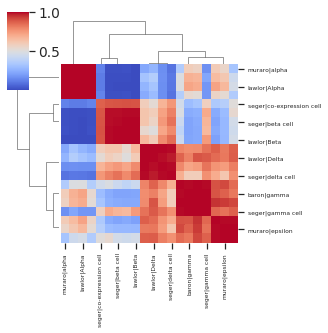

In [19]:
pymn.plotMetaNeighborUS(subdata,cmap='coolwarm')

The resulting heatmap illustrates an example of a strong set of replicating cell types: when the assessment becomes more stringent (restriction to closely related cell types), the similarity of replicating cell types remains strong (AUROC~1 for alpha, beta, gamma, delta and epsilon cells) while the cross-cell-type similarity decreases (shift from red to blue, e.g. similarity of alpha and beta cell types has shifted from orange/red in the global heatmap to dark blue in the endocrine heatmap) by virtue of zooming in on a subpart of the dataset.

15. We can continue to zoom in as long as there are at least two cell types per dataset:

In [20]:
level2_split = pymn.splitClusters(subdata, k=3, save_uns=False)
my_split = level2_split[2]
keep_cell = np.in1d(
    pymn.join_labels(adata.obs['study_id'], adata.obs['cell.type']), my_split)
subdata = adata[keep_cell, ]
pymn.MetaNeighborUS(subdata,
                          study_col='study_id',
                          ct_col='cell.type',
                          fast_version=True)

/home/bharris/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.uns` of view, copying.


/home/bharris/miniconda3/lib/python3.7/site-packages/seaborn/matrix.py:1215: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


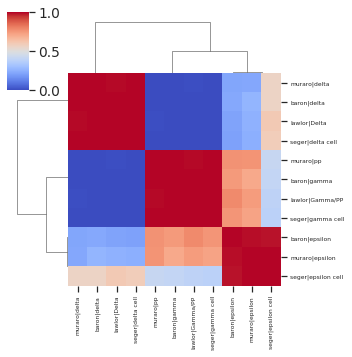

In [21]:
pymn.plotMetaNeighborUS(subdata, cmap='coolwarm')

Here we removed the alpha and beta cells (representing close to 85% of endocrine cells) and validate that, even when restricting to neighboring cell types, there is still a clear distinction between delta, gamma and epsilon cells (AUROC ~ 1).

## Step 3: stringent assessment of replicability with one-vs-best AUROCs

In the previous section, we created progressively more stringent replicability assessments by selecting more and more specific subsets of related cell types. As an alternative, we provide the “one_vs_best” parameter, which offers similar results without having to restrict the dataset manually. In this scoring mode, MetaNeighbor will automatically identify the two closest matching cell types in each test dataset and compute an AUROC based on the voting result for cells from the closest match against cells from the second closest match. Essentially, we are asking how easily a cell type can be distinguished from its closest neighbor.

16. To obtain one-vs-best AUROCs, we run the same command as before with two additional parameters: "one_vs_best = TRUE" and "symmetric_output = FALSE".

In [22]:
pymn.MetaNeighborUS(adata,
                    study_col='study_id',
                    ct_col='cell.type',
                    fast_version=True,
                    symmetric_output=False,
                    one_vs_best=True)

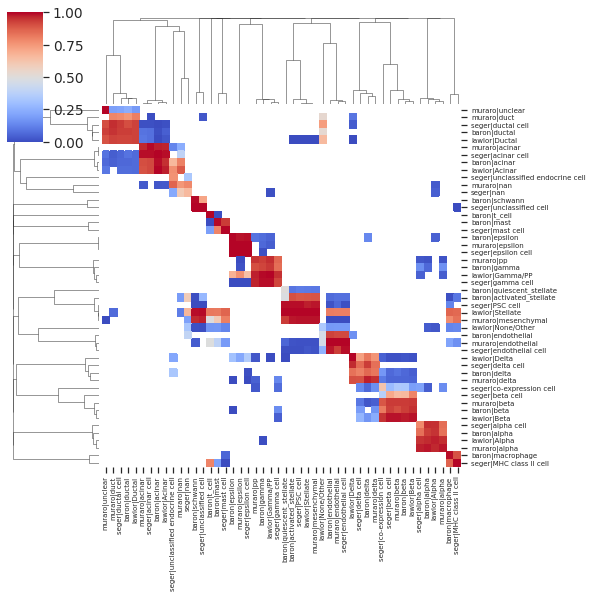

In [23]:
pymn.plotMetaNeighborUS(adata,
                        cmap='coolwarm',
                        figsize=(10, 10),
                        mn_key='MetaNeighborUS_1v1',
                        xticklabels=True,
                        yticklabels=True,
                        fontsize=7)

The interpretation of the heatmap is slightly different compared to one-vs-all AUROCs. First, since we only compare the two closest cell types, most cell type combinations are not tested (NAs, shown in white on the heatmap). Second, by setting “symmetric_output=FALSE”, we broke the symmetry of the heatmap: train cell types are shown as columns and test cell types are shown as rows. Since each cell type is only tested against two cell types in each test dataset (closest and second closest match), we have 8 values per column (2 per dataset).
This representation helps to rapidly identify a cell type’s closest hits as well as their closest outgroup. For example, ductal cells (2nd red square from the top right) strongly match with each other (one-vs-best AUROC>0.8) and acinar cells are their closest outgroup (blue segments in the same column). The non- symmetric view makes it clear when best hits are not reciprocal. For example, mast cells (first two columns) heavily vote for “lawlor|Stellate” and “muraro|mesenchymal”, but this vote is not reciprocal. This pattern indicates that the mast cell type is missing in the Lawlor and Muraro datasets: because mast cells have no natural match in these datasets, they vote for the next closest cell type (stellate cells). The lack of reciprocity in voting is an important tool to detect imbalances in dataset composition.

17.When using one-vs-best AUROCs, we recommend extracting replicating cell types as meta-clusters. Cell types are part of the same meta-cluster if they are reciprocal best hits. Note that if cell type A is the reciprocal best hit of B and C, all three cell types are part of the same meta-cluster, even if B and C are not reciprocal best hits. To further filter for strongly replicating cell types, we specify an AUROC threshold (in our experience, 0.7 is a strong one-vs-best AUROC threshold).

In [24]:
pymn.extractMetaClusters(adata, threshold=.7)
pymn.score_meta_clusters(adata)
mcsummary = adata.uns['MetaNeighborUS_metacluster_scores']
mcsummary[mcsummary.index != 'outliers']

,clusters,n_studies,score
metacluster_1,"[muraro|acinar, lawlor|Acinar, seger|acinar ce...",4,0.964499
metacluster_2,"[baron|activated_stellate, muraro|mesenchymal,...",4,0.966342
metacluster_3,"[baron|alpha, muraro|alpha, seger|alpha cell, ...",4,0.929227
metacluster_4,"[lawlor|Beta, baron|beta, muraro|beta, seger|b...",4,0.890479
metacluster_5,"[seger|delta cell, lawlor|Delta, baron|delta, ...",4,0.873855
metacluster_6,"[lawlor|Ductal, seger|ductal cell, muraro|duct...",4,0.895828
metacluster_7,"[baron|endothelial, muraro|endothelial, seger|...",3,0.962885
metacluster_8,"[baron|epsilon, seger|epsilon cell, muraro|eps...",3,0.997211
metacluster_9,"[baron|gamma, lawlor|Gamma/PP, seger|gamma cel...",4,0.94572
metacluster_10,"[seger|MHC class II cell, baron|macrophage]",2,0.940192


The *scoreMetaClusters* provides a good summary of meta-clusters, ordering cell types by the number of datasets in which they replicate, then by average AUROC. We find 12 cell types that have strong support across at least 2 datasets, with 7 cell types replicating across all 4 datasets. 8 cell types are tagged as "outlier", as they had no strong match. These cell types usually contain doublets, low quality cells or contaminated cell types. The replicability structure described here can be summarized as an Upset plot.

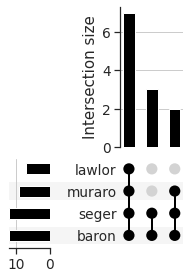

In [25]:
pymn.plotUpset(adata)

To further investigate the robustness of meta-clusters, they can be visualized as heatmaps (called “cell-type badges”) with the plotMetaClusters function. Because the function generates one heatmap per meta-cluster, we save the output to a PDF file to facilitate investigation. Each badge shows an AUROC heatmap restricted to one specific meta-cluster. These badges help diagnose cases where AUROCs are lower in a specific train or test dataset. For example, the “muraro|duct” cell type has systematically lower AUROCs, suggesting the presence of contaminating cells in another cell type (probably in the “muraro|unclear” cell type).

> **Note** This is not yet implemented 

In [26]:
####### Not yet implemented #########

# pdf("meta_clusters.pdf")
# plotMetaClusters(mclusters, best_hits)
# dev.off()

18. The last visualization is an alternative representation of the AUROC heatmap as a graph, which is particularly useful for large datasets. In this graph, top votes (AUROC > 0.5) are shown in gray, while outgroup votes (AUROC < 0.5) are shown in orange. To highlight close calls, we recommend keeping only strong outgroup votes, here with AUROC >= 0.3.

/home/bharris/pyMN/pymn/plotting.py:383: RuntimeWarning: invalid value encountered in greater
  (best_hits.values < low_threshold)] = 0
/home/bharris/pyMN/pymn/plotting.py:383: RuntimeWarning: invalid value encountered in less
  (best_hits.values < low_threshold)] = 0


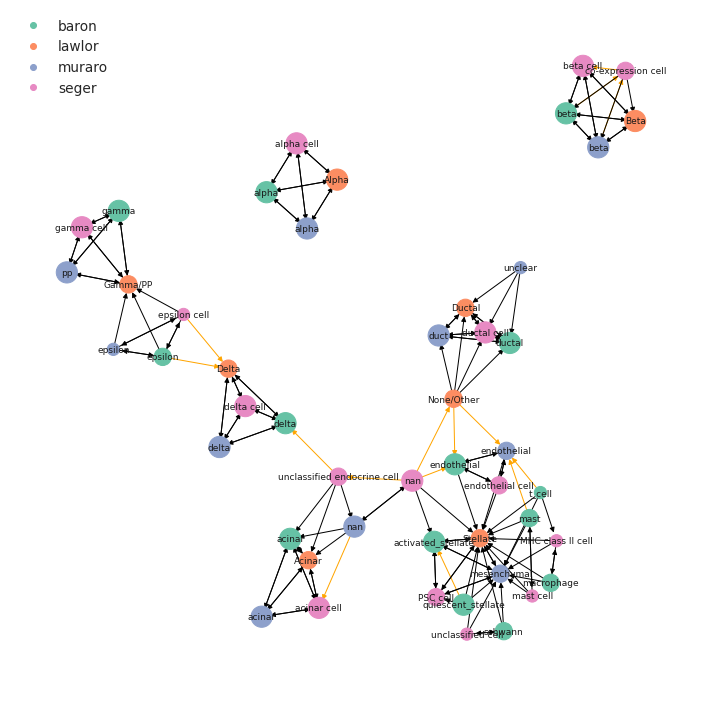

In [27]:
pymn.makeClusterGraph(adata, low_threshold=.3)
pymn.plotClusterGraph(adata, font_size=9, figsize=(10, 10))

We note that there are several orange edges, indicating that some cell types had two close matches. To investigate the origin of these close calls, we can focus on a cluster of interest (coi). Here we take a closer look at “baron|epsilon”, query its closest neighbors in the graph with *extendClusterSet*, then zoom in on its subgraph by passing the list of clusters to the *plotClusterGraph* function in order to subset the graph and plot it.

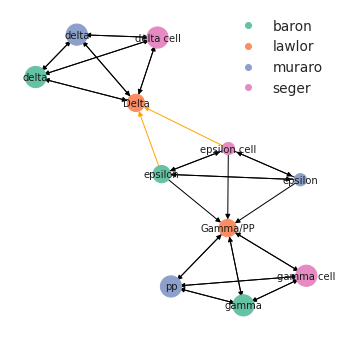

In [28]:
coi = "baron|epsilon"
coi = pymn.extendClusterSet(adata=adata, coi=coi, max_neighbor_distance=2)
pymn.plotClusterGraph(adata, node_list=coi, font_size=10, figsize=(5, 5))

In the “baron|epsilon” case, we find that the epsilon cell type is missing in the Lawlor dataset, so there is no natural match for the Baron epsilon cell type. In such cases, votes are frequently non-reciprocal and equally split between two unrelated cell types, here “Lawlor|Gamma/PP” and “Lawlor|Alpha”. In general, the cluster graph can be used to understand how meta-clusters are extracted, why some clusters are tagged as outliers and diagnose problems where the resolution of cell types differs across datasets.